# Quickstart AltaiPony: De-trend and find flares

Let's first get the base class and the IO function we want to use:

In [1]:
from altaipony.flarelc import FlareLightCurve
from altaipony.lcio import from_mast

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Now download a **K2SC** light curve from archive and create a ``FlareLightCurve``.


In [2]:
EPIC = 211983544
# c is the campaign for K2, sector for TESS, and quarter for Kepler
flc = from_mast(EPIC, mode="TPF", mission="K2", c=18)

5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


Let's verify that we succeeded:

In [3]:
flc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality,detrended_flux,detrended_flux_err
,electron / s,electron / s,pix,pix,,,,
object,float32,float32,float64,float64,int32,int32,float64,float64
3418.5462985357226,655.2529296875,2.001539468765259,744.3878921520364,798.5000278918473,161969,524288,nan,nan
3418.566730889026,654.7945556640625,2.001585006713867,744.3801263304479,798.5000279113723,161970,0,nan,nan
3418.5871630423353,653.291015625,2.0012948513031006,744.375749776709,798.4999626991868,161971,0,nan,nan
3418.6075953947147,657.9308471679688,2.001985788345337,744.363499084933,798.4999907405595,161972,0,nan,nan
3418.628027647086,657.8167724609375,2.0020687580108643,744.3610904594871,798.5000277831386,161973,0,nan,nan
3418.6484598985335,665.3134155273438,2.0033533573150635,744.3539806793178,798.4999816866115,161974,0,nan,nan
3418.668892149515,667.2531127929688,2.0035789012908936,744.3451990893935,798.5000182601517,161975,0,nan,nan
3418.689324400024,668.6802368164062,2.0038747787475586,744.3433921569012,798.4999726682297,161976,0,nan,nan


The representation tells us that we have indeed created a ``FlareLightCurve``, and shows the data in an ``astropy`` table.

Now let's look at some cool tools we inherited from the awesome [``lightkurve``](https://github.com/KeplerGO/lightkurve) package:

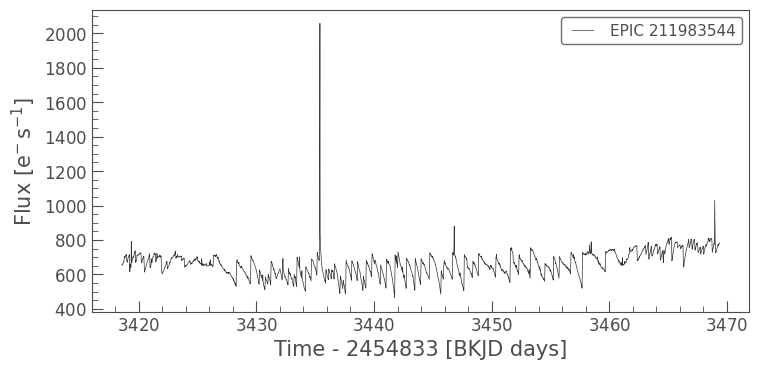

In [4]:
%matplotlib inline
flc.plot();

This is the raw light curve. The is intrumental noise but also stellar variability. Let's remove it with K2SC:

In [5]:
flcd = flc.detrend("k2sc")

Starting initial outlier detection at 3sigma.
  Flagged 32 ( 1.3%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    1.69 (fap 2.6093e-310 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -2600.620277781531
  DE iteration %3i -ln(L) %4.1f 1 -2600.620277781531
  DE iteration %3i -ln(L) %4.1f 2 -2600.620277781531
  DE iteration %3i -ln(L) %4.1f 3 -2600.6362233580594
  DE iteration %3i -ln(L) %4.1f 4 -2600.6362233580594
  DE iteration %3i -ln(L) %4.1f 5 -2600.6362233580594
  DE iteration %3i -ln(L) %4.1f 6 -2600.6362233580594
  DE iteration %3i -ln(L) %4.1f 7 -2600.6362233580594
  DE iteration %3i -ln(L) %4.1f 8 -2601.039478788755
  DE iteration %3i -ln(L) %4.1f 9 -2601.039478788755
  DE iteration %3i -ln(L) %4.1f 10 -2601.2816370248265
  DE iteration %3i -ln(L) %4.1f 11 -2601.2816370248265
  DE iteration %3i -ln(L) %4.1f 12 -2601.342170972774
  DE iteratio

De-trending successfully completed.


  CDPP - raw - %6.3f 38213.18792627427
  CDPP - position component removed - %6.3f 8182.142893059746
  CDPP - full reduction - %6.3f 2381.909634613393
Detrending time 206.70626091957092


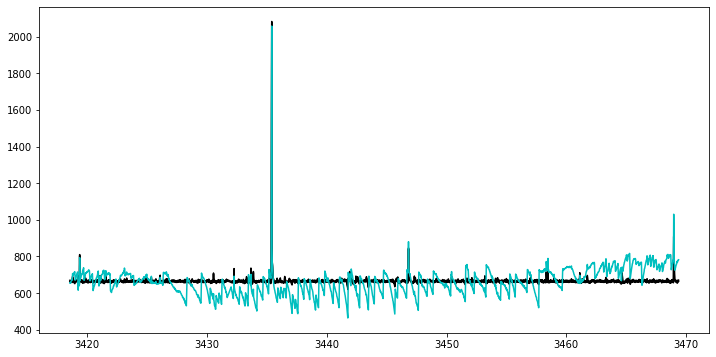

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(flcd.time.value, flcd.detrended_flux.value, c='k')
plt.plot(flcd.time.value, flcd.detrended_flux.value + flcd.detrended_flux_err.value * 3, c='k')
plt.plot(flcd.time.value, flcd.flux.value, c='c')

**K2SC** preserved flare signal, so this is what we use for flare finding.

So let us find the flares in this light curve (one, at least, is pretty obvious, right?)

Often, the uncertainty in the detrended flux is underestimated, and we need a better proxy for the noise. for simplicity, we choose to increase the noise level by a factor of three, but you can also pick the standard deviation of the residuals or some other metric. 

In [14]:
flcd.detrended_flux_err = flcd.detrended_flux_err * 3
flcd.detrended_flux_err

<Quantity [6.0046186, 6.004755 , 6.0038843, ..., 6.1921673, 6.1937847,
           6.1935415] electron / s>

In [15]:
flcd = flcd.find_flares()
flcd.flares.sort_values(by="ed_rec", ascending=False)

Found 0 candidate(s) in the (0,618) gap.
Found 4 candidate(s) in the (618,2371) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,775,783,162792,162800,3435.361892,3435.525347,7223.266350,29.046990,2.139773,0.163455,2371.0
3,2351,2354,164437,164441,3468.972071,3469.053797,1651.945086,39.486573,0.367844,0.081726,2371.0
1,1311,1314,163352,163355,3446.803711,3446.865006,745.246894,23.528121,0.271179,0.061295,2371.0
2,2155,2158,164225,164228,3464.640564,3464.701859,261.023163,27.714030,0.065034,0.061295,2371.0


Aha! Some flare candidates. Not all visible outliers qualify for flare candidates, because we require a minimum a minimum of three outliers in a row for any candidate. We also apply a set of other criteria, which you can read up on [here in the docs](https://altaipony.readthedocs.io/en/latest/tutorials/altai.html).


Let's see where they are in the light curve and zoom in on the big one:

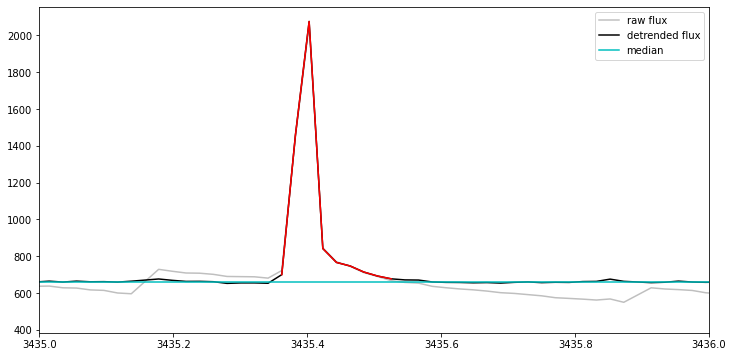

In [20]:
plt.figure(figsize=(12,6))
plt.plot(flcd.time.value, flcd.flux.value, c='grey', alpha=.5, label='raw flux')
plt.plot(flcd.time.value, flcd.detrended_flux.value, c='k', label='detrended flux')
plt.plot(flcd.time.value, flcd.it_med.value, c='c', label='median')
for i,f in flcd.flares.iterrows():
    plt.plot(flcd.time.value[f.istart:f.istop+1],
             flcd.detrended_flux.value[f.istart:f.istop+1], c='r')
plt.xlim(3435,3436)
# plt.xlim(3464,3465) # uncomment this and the line below to see a small candidate
# plt.ylim(600,900) # uncomment this and the line above to see a small candidate zoomed in
plt.legend();

Not all of them are real, others are real but are detected only by chance. Here is where injecting synthetic events comes in. But this is a story for a different notebook, and is a computational challenge if you wish to quantify the effects that K2SC GP de-trending has on the flare energies and recovery probabilities.

Questions? Something does not work? Email me @ eilin@aip.de 